In [1]:
%matplotlib inline

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt; plt.style.use('classic')
import seaborn as sns; sns.set()

Let $X: \mathbb{R} \to \mathbb{R}$ be a random variable following a distribution, which consists of a mixture of two univariate gaussians. Specifically, for an observation $x \in \operatorname{Im}(X)$ let the probability density function be defined as:

$$
p( x ) =  0.3 \, \mathcal{N}(-20, 10)(x) + 0.7 \, \mathcal{N}(20, 10)(x).
$$

In [2]:
def gaussian(x, mu, sigma ):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) )

def p(x):
    mu_1    = -20
    sigma_1 = 10
    mu_2    = 20
    sigma_2 = 10
    return 0.3 * gaussian(x, mu_1, sigma_1) + 0.7 * gaussian(x, mu_2, sigma_2)

We sample $N$ observations $\{ x_n : n= 1, \ldots, N \}$ of the random variable $X$.

Out goal is then to estimate the parameters of the distribution which give rise to the maximum likelihood explaining the observations.

In [3]:
def observe_data(N, mu, sigma, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[:int(f*N)] *= sigma[0]
    x[:int(f*N)] += mu[0]
    
    x[int(f*N):] *= sigma[1]
    x[int(f*N):] += mu[1]
    
    return x


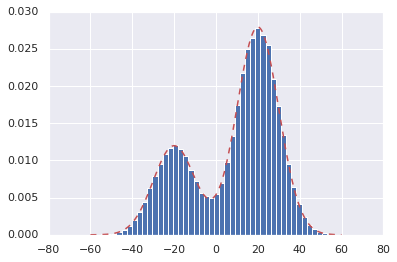

In [4]:
N = 100000
mu    = [-20, 20]
sigma = [10,10] 
samples = observe_data(N, mu, sigma)

plt.figure()
plt.hist(samples, bins=50, density=True)

xN    = 500

X  = np.arange(-60, 60, 2./xN)
Y  = [ p(x) for x in X ]

plt.plot(X,Y, 'r--')

plt.show()

To denote the similarity of an estimated probability density function $q$ and a true probability density function $p$ we make use of the Kullback-Leibler Divergence:

$$
D(p\|q)=KL(p,q)=\int _{X} p(x) \cdot \log {p(x) \over q(x)} \mathrm{d}x
$$


In [5]:
def KL_divergence(p, q, x):    
    assert(p.shape == q.shape)

    tmp = np.where(p != 0, p * np.log2(p / q), 0)
    return np.trapz(tmp, x)    


Assuming a gaussian mixture model, the parameters we want to estimate are the mean values $\mu_k$, the standard deviations $\sigma_k$, and the mixture weights $\pi_k$, for $k=1,2$.

For that, we introduce for $k=1,2$ the random variable $Z_k$ as the hidden variables of our model, where we denote its realizations as $z_k$, we introduce the random variable $M_k$ for the mean values, where we denote its realizations as $\mu_k$, the random variables $\Sigma_k$ for the standard deviations, where we denote its realizations as $\sigma_k$, and finally the random variable $\Pi_k$ for the mixture weights, where we denote its realizations as $\pi_k$. We assume that these random variables are distributed in the following way: 

From [Murphy, Chapter 24.2.3]

Suppose we use a semi-conjuage prior. Then the full joint distribution is given by

$$
p(\mathbf{x},\mathbf{z},\mathbf{\mu}, \mathbf{\sigma}, \mathbf{\pi}) 
= p(\mathbf{x} | \mathbf{z}, \mathbf{\mu}, \mathbf{\sigma} ) \,
p(\mathbf{z} | \mathbf{\pi})
p(\mathbf{\pi})
\prod_{k=1}^K p(\mathbf{\mu_k}) p(\mathbf{\sigma_k})
$$

We use the same prior for each mixture component. The full conditionals are as follows. For the discrete indicators, we have

$$
p(z_i = k \, | x_i, \mathbf{\mu}, \mathbf{\sigma}, \mathbf{\pi})
\propto \mathcal{N}( x_i | \mu_k, \sigma_k)
$$

For the mixing weights, we have

$$
p(\mathbf{\pi} \, | \mathbf{z}) 
= \operatorname{Dir}\big( \mathbf{\pi} \, \big\rvert \big\{ \alpha_k + \sum_{i=1}^N \mathbf{1}(z_i =k) : k = 1 \ldots K \big\}\big)
$$

For the means, we have

$$
p(\mu_k \, | \sigma_k, \mathbf{z}, \mathbf{x})
= \mathcal{N}( \mu_k \, | m_k, V_k )
$$

where
$$
\begin{aligned}
N_k &= \sum_{i=1}^N \mathbf{1}(z_i = k )\\
\bar{x}_k &= \frac{\sum_{i=1}^N \mathbf{1}(z_i=k) x_i}{N_k}\\
V_k^{-1} &= V_0^{-1} + N_k \sigma_k^{-1}\\
m_k &= V_k ( \Sigma_k^{-1} N_k \bar{x}_k + V_0^{-1} m_0)
\end{aligned}
$$


For the covariances, we have

$$
p(\Sigma_k | \mu_k, \mathbf{z}, \mathbf{x})
= \operatorname{IW}(\Sigma_k | S_k, \nu_k)
$$

where
$$
\begin{aligned}
S_k &= S_0 + \sum_{i=1}^N \mathbf{1}(z_i = k) (x_i - \mu_k)(x_i - \mu_k)^{T}\\
\nu_k &= \nu_0 + N_k
\end{aligned}
$$

Given observations $\{ x_n : n = 1, \ldots, N \}$ and assuming a mixture of two univariate gaussians, we estimate our model parameters with the Gibbs sampling algorithm in the following way:

Initialize $\mu_k, \sigma_k, \pi_k$, for $k=1,2$.

For $n = 1,\ldots, N$:

Sample $z^{(n+1)} \sim p( Z | \mu^{(n)}, \sigma^{(n)}, \pi^{(n)}, x)$

Sample $\pi_k^{(n+1)} \sim p( \, \Pi_k \, | z^{(n+1)})$.

Sample $\mu_k^{(n+1)} \sim p( M_k \, | \sigma_k^{(n)}, z^{(n+1)}, x)$.

Sample $\sigma_k^{(n+1)} \sim p( \Sigma_k \, | \mu_k^{(n+1)}, z^{(n+1)}, x)$.



In [6]:
def gibbs_sampling_step(samples, K, pi_K, mu_K, sigma_K, alpha_K, V_0=1, m_0=1, S_0=0, nu_0=0):
    
    mu_K = mu_K.reshape(K,1)
    sigma_K = sigma_K.reshape(K,1)
    
    # iteration for z
    z = np.argmax(pi_K.reshape(K,1) * gaussian(samples, mu_K, sigma_K), axis=0)
    
    # iteration for mu_K
    N_K = np.vstack([sum(z==k) for k in range(K)])
    x_avg = np.vstack([sum((z==k)*np.asarray(samples)) / N_K[k] for k in range(K)])
     
    V_K = 1/(1/V_0 + N_K * 1/sigma_K)
    m_K = V_K * (1/sigma_K * N_K * x_avg + 1/V_0 * m_0)
        
    mu_K = np.random.normal(m_K, V_K)
    #mu_K = np.vstack((-20, 20)) #use true values for testing

    # iteration for sigma_K
    tmp = np.power(samples-mu_K,2)
    S_K = [ S_0 + sum((z==k)*tmp[k,:]) for k in range(K) ] 
    nu_K = nu_0 + N_K.ravel()

    sigma_K = np.vstack([ np.sqrt(stats.invwishart.rvs(df=nu_K[k], scale=S_K[k])) for k in range(K) ])
    #sigma_K = np.vstack((10,10)) #use true values for testing
        
    # iteration for pi_K
    alpha_K = alpha_K + N_K.ravel()
    pi_K = (np.random.dirichlet(alpha_K, 1)).ravel()
    #pi_K = np.vstack((0.3, 0.7)) #use true values for testing
    
    return (pi_K, mu_K.ravel(), sigma_K.ravel(), alpha_K)


In [7]:
def univariate_gmm_gibbs_sampling(K, NSteps, verbose=False):
    # init values of random variables
    pi_K    = 0.5*np.ones(K)
    mu_K    = np.arange(K)
    sigma_K = np.ones(K)
    alpha_K = np.ones(K) # a-priori parameters for pi_K

    # init calculation for KL-Divergence
    sampled_Y = np.empty(len(X))
    kl_divs   = []

    for n in range(1,NSteps+1):
        pi_K, mu_K, sigma_K, alpha_K = gibbs_sampling_step(samples, K, pi_K, mu_K, sigma_K, alpha_K)
    
        sampled_Y = np.sum(pi_K.reshape(K,1) * gaussian(X, mu_K.reshape(K,1), sigma_K.reshape(K,1)), axis=0)        
        kl = KL_divergence(p(X), sampled_Y, X); kl_divs.append(kl)
    
        if(verbose):
            print("iteration {0:2}: KL-divergence = {1:3.5f}".format(n, kl))
        
    return (pi_K, mu_K, sigma_K, kl_divs)


In [8]:
K = 2 # number of mixtures
NSteps = 10

pi_K, mu_K, sigma_K, kl_divs = univariate_gmm_gibbs_sampling(K, NSteps, True)

iteration  1: KL-divergence = 0.05678
iteration  2: KL-divergence = 0.00652
iteration  3: KL-divergence = 0.00341
iteration  4: KL-divergence = 0.00259
iteration  5: KL-divergence = 0.00217
iteration  6: KL-divergence = 0.00235
iteration  7: KL-divergence = 0.00248
iteration  8: KL-divergence = 0.00238
iteration  9: KL-divergence = 0.00231
iteration 10: KL-divergence = 0.00222


estimated mixture coefficients:  [0.306 0.694]
estimated mean values:  [-20.448  20.07 ]
estimated standard deviations:  [9.322 9.842]


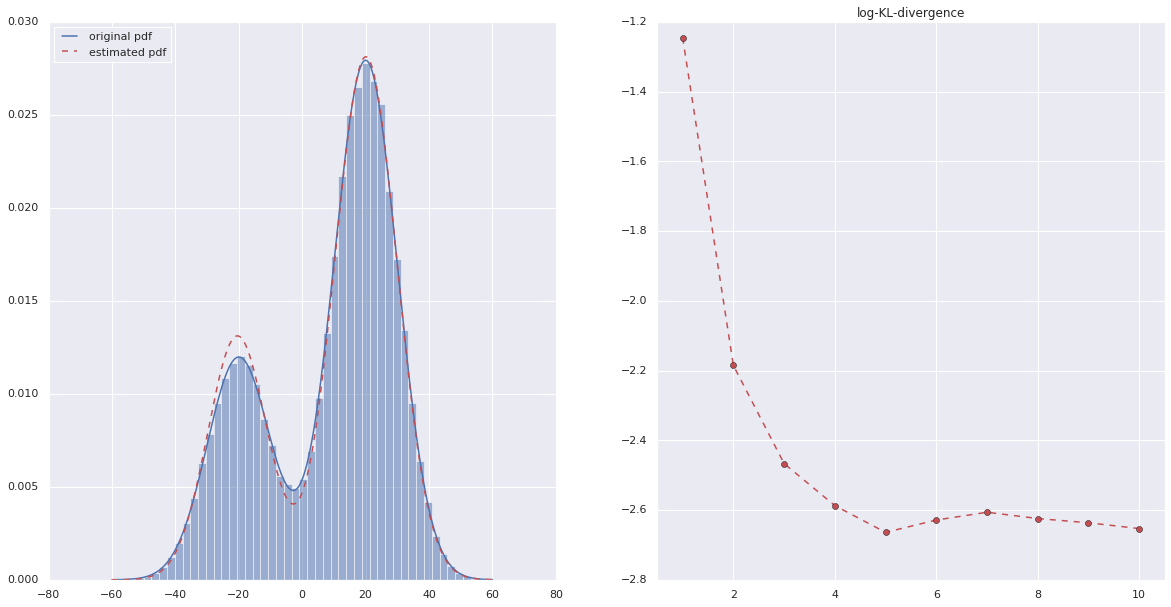

In [9]:
np.set_printoptions(precision=3)
print("estimated mixture coefficients: ", pi_K)
print("estimated mean values: ", mu_K)
print("estimated standard deviations: ", sigma_K)

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.hist(samples, bins=50, density=True, alpha=0.5)
plt.plot(X, p(X), 'b-', label="original pdf")

sampled_Y = np.sum(pi_K.reshape(K,1) * gaussian(X, mu_K.reshape(K,1), sigma_K.reshape(K,1)), axis=0)
plt.plot(X, sampled_Y, 'r--', label="estimated pdf" )
plt.legend(loc='upper left')
#plt.show()

plt.subplot(1,2,2)
plt.plot(list(range(1,NSteps+1)), np.log10(kl_divs), 'ro--')
plt.xlim(0.5, NSteps+0.5)
plt.title("log-KL-divergence")
plt.show()

**TODO**: Graphical model to show that an observation of $z$ makes $\{x_n : n = 1 \ldots N \}$ conditionally independent.

From [Bishop, Chapter 9.2]

We introduce a $2$-dimensional random variable $Z$ having a $1$-of-$2$ representation in which a particular element $z_k$, $k=1,2$, is equal to $1$ and the other element is equal to $0$. 
The random variable $Z$ follows the Bernoulli distribution with parameters given by the mixture coefficients $\pi_k$, $k=1,2$, i.e., the probability of a realization $z_k = 1$ of the random variable $Z$ is:
$$
p(z_k = 1) = \pi_k,
$$
for $k=1,2$.
Hence, 
$$
p( Z = (z_1, z_2) ) = \pi_1^{z_1} \, \pi_2^{z_2}.
$$
The conditional distribution of the realization $x$ given realization $z$ is
$$
p( x \, | z ) = \mathcal{N}(x \, | \mu_0, \sigma_0)^{z_0} 
\, \mathcal{N}(x \, | \mu_1, \sigma_1)^{z_1}.
$$

Overall, we have then

$$
p( x ) = \sum_{z} p(z) p(x \, | z) = \pi_0 \mathcal{N}(x \, | \mu_0, \sigma_0) + \pi_1 \mathcal{N}(x \, | \mu_1, \sigma_1)
$$